In [15]:
import compressai
import importlib
import json
import os
import random
import numpy as np
import torch
from pathlib import Path
import json
import glob 
from compressai.datasets.rawvideo import RawVideoSequence

eval_model = importlib.import_module("compressai.utils.video.eval_model.__main__")

# Derive the directory containing the notebook file
checkpoint = "checkpoints/checkpoint_8_best_recent.pth.tar"
assert os.path.isfile(checkpoint)
model = 'ssf2020'
metric = 'mse'
here = Path('tmp/out.bin')

In [ ]:
net = eval_model.load_checkpoint(model, False, checkpoint)

In [21]:
from torch.hub import load_state_dict_from_url

from compressai.models.video import ScaleSpaceFlow

from compressai.zoo.pretrained import load_pretrained

url = 'https://compressai.s3.amazonaws.com/models/v1/ssf2020-mse-9-e89345c4.pth.tar'
# url = 'https://compressai.s3.amazonaws.com/models/v1/ssf2020-mse-3-9c8b998d.pth.tar'
progress=True
state_dict = load_state_dict_from_url(url, progress=progress)
state_dict = load_pretrained(state_dict)
model = ScaleSpaceFlow.from_state_dict(state_dict)

In [24]:
video = Path('assets/dataset/video/C_RaceHorses_2frames_832x480_30Hz_8bit_P420.yuv')
result = eval_model.eval_model(net, video,here)

 encoding C_RaceHorses_2frames_832x480_30Hz_8bit_P420
100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.03it/s]


In [25]:
# print(' Our results : ', result)
with open('expected/eval_0_ssf2020_mse_8.json', 'r') as file:
    data = json.load(file)
expected_result =  data['results']

print(f"{'Metric':<15}{'Ours':<20}{'Expected':<20}")
print("-" * 55)
for metric, value in result.items():
    expected_value = expected_result[metric][0] if metric in expected_result else "N/A"
    print(f"{metric:<15}{value:<20}{expected_value:<20}")

Metric         Ours                Expected            
-------------------------------------------------------
psnr-y         31.539241790771484  38.320213317871094  
psnr-u         37.8870849609375    42.999244689941406  
psnr-v         39.13776397705078   43.85735321044922   
psnr-yuv       33.86363983154297   40.022911071777344  
ms-ssim-rgb    0.964973509311676   0.9934679269790649  
mse-rgb        57.340843200683594  12.823404312133789  
psnr-rgb       30.546234130859375  37.22743225097656   
bitrate        6574.68             22620.12            


In [4]:
from compressai.datasets import VideoFolder
from torchvision import transforms

train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.RandomCrop(256)]
)

train_dataset = VideoFolder(
    '/data/maryam.sana/vimeo_septuplet/',
    rnd_interval=True,
    rnd_temp_order=True,
    split="train",
    transform=train_transforms,
)

In [7]:
train_dataset.max_frames 

8

In [9]:
org_seq = RawVideoSequence.from_file(str(video))
no_frames = len(org_seq)
binpath = (result['bitrate']*1000*no_frames)/(8*org_seq.framerate)
print(binpath)

54109.0


In [10]:
print('no frames', no_frames)
dim = video.stem.split('_')[3]
print('dim:', dim)
w,h = dim.split('x')
pixels = no_frames*int(w)*int(h)
print('total pixels in video:', pixels)

bpp = binpath/pixels

print('bpp: ', bpp)

no frames 2
dim: 832x480
total pixels in video: 798720
bpp:  0.06774464142628205


In [20]:
quality_3_results = glob.glob('UVG_results/quality_3/*.json')
videos = glob.glob('/data/maryam.sana/UVG/*.yuv')

In [25]:
def calculate_bpp(video_path: str, json_path: str) -> dict:
    # Load JSON file
    with open(json_path, 'r') as f:
        json_data = json.load(f)

    # Load video sequence
    video_file = Path(video_path)
    org_seq = RawVideoSequence.from_file(str(video_file))
    no_frames = len(org_seq)

    # Calculate bitrate
    bitrate = json_data['bitrate']
    binpath = (bitrate * 1000 * no_frames) / (8 * org_seq.framerate)

    # Calculate dimensions and total pixels
    # print(video_file.stem.split('_'))
    dim = video_file.stem.split('_')[1]
    w, h = map(int, dim.split('x'))
    pixels = no_frames * w * h

    # Calculate bits per pixel (bpp)
    bpp = binpath / pixels

    # Add bpp to JSON data
    json_data['bpp'] = float(bpp)

    return json_data


In [27]:
data_q3 = []
for json_file in quality_3_results:
    video_file = '/data/maryam.sana/UVG/' + Path(json_file).stem + '.yuv'
    print(video_file)
    r = calculate_bpp(video_file, json_file)
    data_q3.append(r)

/data/maryam.sana/UVG/Jockey_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/FlowerPan_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/Beauty_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/FlowerKids_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/HoneyBee_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/ShakeNDry_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/Twilight_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/RaceNight_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/CityAlley_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/YachtRide_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/Lips_3840x2160_120fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/FlowerFocus_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/RiverBank_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/SunBath_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/Bosphorus_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG

In [30]:
import statistics 

def get_mean(data_q3):
    bpp_values = [entry['bpp'] for entry in data_q3]
    psnr_rgb_values = [entry['psnr-rgb'] for entry in data_q3]
    ms_ssim_rgb_values = [entry['ms-ssim-rgb'] for entry in data_q3]
    
    # Calculate mean bpp, mean psnr-rgb, and mean ms-ssim-rgb
    mean_bpp = statistics.mean(bpp_values)
    mean_psnr_rgb = statistics.mean(psnr_rgb_values)
    mean_ms_ssim_rgb = statistics.mean(ms_ssim_rgb_values)
    return mean_bpp, mean_psnr_rgb, mean_ms_ssim_rgb


In [31]:
mean_bpp, mean_psnr_rgb, mean_ms_ssim_rgb = get_mean(data_q3)

print("Mean bpp:", mean_bpp)
print("Mean psnr-rgb:", mean_psnr_rgb)
print("Mean ms-ssim-rgb:", mean_ms_ssim_rgb)

Mean bpp: 0.020437851517288774
Mean psnr-rgb: 35.96308350563049
Mean ms-ssim-rgb: 0.9595210216939449


In [33]:
quality_8_results = glob.glob('UVG_results/quality_8/*.json')
videos = glob.glob('/data/maryam.sana/UVG/*.yuv')

data_q8 = []
for json_file in quality_8_results:
    video_file = '/data/maryam.sana/UVG/' + Path(json_file).stem + '.yuv'
    print(video_file)
    r = calculate_bpp(video_file, json_file)
    data_q8.append(r)

/data/maryam.sana/UVG/Jockey_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/FlowerPan_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/Beauty_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/FlowerKids_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/HoneyBee_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/ShakeNDry_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/Twilight_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/RaceNight_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/CityAlley_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/YachtRide_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG/Lips_3840x2160_120fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/FlowerFocus_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/RiverBank_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/SunBath_3840x2160_50fps_420_10bit_YUV.yuv
/data/maryam.sana/UVG/Bosphorus_1920x1080_120fps_420_8bit_YUV.yuv
/data/maryam.sana/UVG

In [34]:
mean_bpp, mean_psnr_rgb, mean_ms_ssim_rgb = get_mean(data_q8)

print("Mean bpp:", mean_bpp)
print("Mean psnr-rgb:", mean_psnr_rgb)
print("Mean ms-ssim-rgb:", mean_ms_ssim_rgb)

Mean bpp: 0.02384233571747203
Mean psnr-rgb: 34.862271308898926
Mean ms-ssim-rgb: 0.9551374390721321


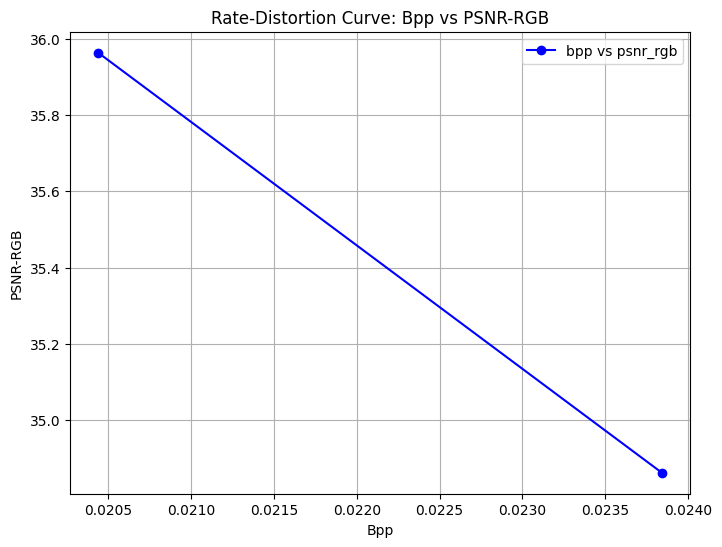

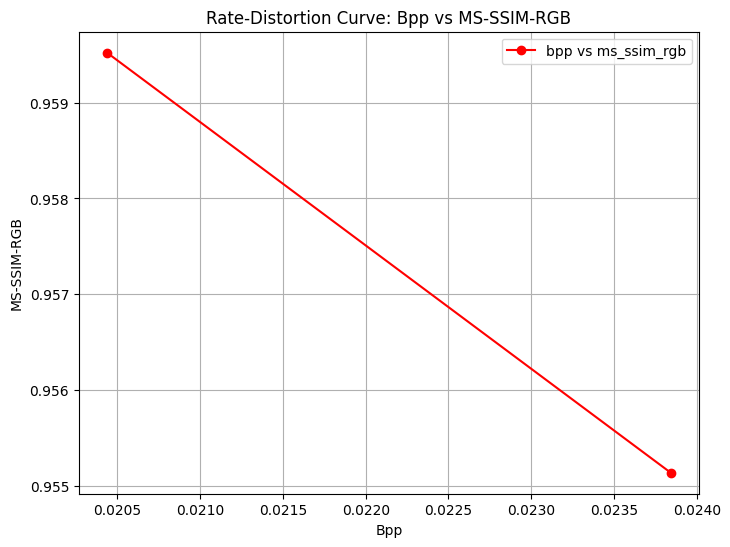

In [49]:
import matplotlib.pyplot as plt

# Example data
bpp = [0.02384233571747203, 0.020437851517288774]
psnr_rgb = [34.862271308898926, 35.96308350563049]
ms_ssim_rgb = [0.9551374390721321, 0.9595210216939449]

# Plot bpp vs psnr_rgb
plt.figure(figsize=(8, 6))
plt.plot(bpp, psnr_rgb, marker='o', linestyle='-', color='b', label='bpp vs psnr_rgb')
plt.xlabel('Bpp')
plt.ylabel('PSNR-RGB')
plt.title('Rate-Distortion Curve: Bpp vs PSNR-RGB')
plt.grid(True)
plt.legend()
plt.savefig('psnr.png')
plt.show()

# Plot bpp vs ms_ssim_rgb
plt.figure(figsize=(8, 6))
plt.plot(bpp, ms_ssim_rgb, marker='o', linestyle='-', color='r', label='bpp vs ms_ssim_rgb')
plt.xlabel('Bpp')
plt.ylabel('MS-SSIM-RGB')
plt.title('Rate-Distortion Curve: Bpp vs MS-SSIM-RGB')
plt.grid(True)
plt.legend()
plt.savefig('mssim.png')
plt.show()


In [18]:
from torch.hub import load_state_dict_from_url

from compressai.models.video import ScaleSpaceFlow

from compressai.zoo.pretrained import load_pretrained

url = 'https://compressai.s3.amazonaws.com/models/v1/ssf2020-mse-9-e89345c4.pth.tar'
# url = 'https://compressai.s3.amazonaws.com/models/v1/ssf2020-mse-3-9c8b998d.pth.tar'
progress=True
state_dict = load_state_dict_from_url(url, progress=progress)
state_dict = load_pretrained(state_dict)
model = ScaleSpaceFlow.from_state_dict(state_dict)


In [11]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 133.149MB
